### We begin with boilerplate:

In [1]:
%matplotlib inline 
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = [18, 6]

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import numpy as np
import random
import pandas as pd
import os
import sys

In [4]:
import logging
logging.basicConfig(format='%(asctime)s %(levelname)s:%(message)s', level=logging.INFO)

# First simulate a sensible setup:

In [5]:
# point at library; I need some lessons on doing good PYTHONPATHs:
REPO_DIR = os.path.dirname(os.getcwd())
sys.path.append(os.path.join(REPO_DIR, 'lib'))

from disease import Covid
from outbreak import Outbreak
import society.lateral
from population.covid import PersonCovid
from population.networks.household_workplace import HouseholdWorkplacePopulation

We are going to work with a small town of a few thousand people.

We will place the population that we have created, into various settings and societies in the upcoming simulations

In [6]:
POP_SIZE = 780000 // 5 # begin with 56
PREVALENCE = 1/80

In [7]:
pop = HouseholdWorkplacePopulation(POP_SIZE, society.Society(), person_type=PersonCovid)

2020-12-06 10:47:22,586 INFO:Building households
2020-12-06 10:47:22,592 INFO:Mean size is 2.736842105263158
2020-12-06 10:47:28,221 INFO:Done households, now moving on to workplaces
2020-12-06 10:47:28,234 INFO:Mean size is 5.615384615384615
2020-12-06 10:47:47,715 INFO:Composing households and workplaces


In [8]:
SCALE_SETTINGS = dict(n_days = 61, pop_size = POP_SIZE, seed_size = int(POP_SIZE*PREVALENCE), population=pop)
SCALE_SETTINGS

{'n_days': 61,
 'pop_size': 156000,
 'seed_size': 1950,
 'population': <population.networks.household_workplace.HouseholdWorkplacePopulation at 0x288fd7e8278>}

In [9]:
lf = society.lateral.LateralFlowUK(config=dict(SIMULATOR_PERIODS_PER_DAY=4, DAILY_TEST_CAPACITY_PER_HEAD=0.0075))
lf.GENERAL_VALENCY_QUANTILE_THRESHOLD = 0.8
lf.VALENCY_TEST_FREQUENCY_DAYS = 3
lf.RETEST_POSITIVE_CASES = True
lf.LATERAL_TO_PCR_RATIO = 15

o = Outbreak(lf, Covid(), **SCALE_SETTINGS)

2020-12-06 10:48:14,261 INFO:The city has 20x the number of lateral flow tests available, as PCRs
2020-12-06 10:48:14,264 WARNING:Using a pre-existing population - does it have the right network structure?


In [10]:
o.simulate()

2020-12-06 10:48:19,860 INFO:Setting mass testing valency/degree limit to 17
2020-12-06 10:48:24,445 INFO:Day 0, prop infected is 0.01, prop infectious is 0.0064
2020-12-06 10:56:12,078 INFO:Day 50, prop infected is 0.06, prop infectious is 0.0022
2020-12-06 10:57:11,091 INFO:Day 61, prop infected is 0.06, prop infectious is 0.0013


In [11]:
soc = lf

2020-12-06 10:57:11,429 INFO: Realized R0 of early infections is 0.80
2020-12-06 10:57:11,430 INFO: 5.9 percent of the proportion was infected during the epidemic


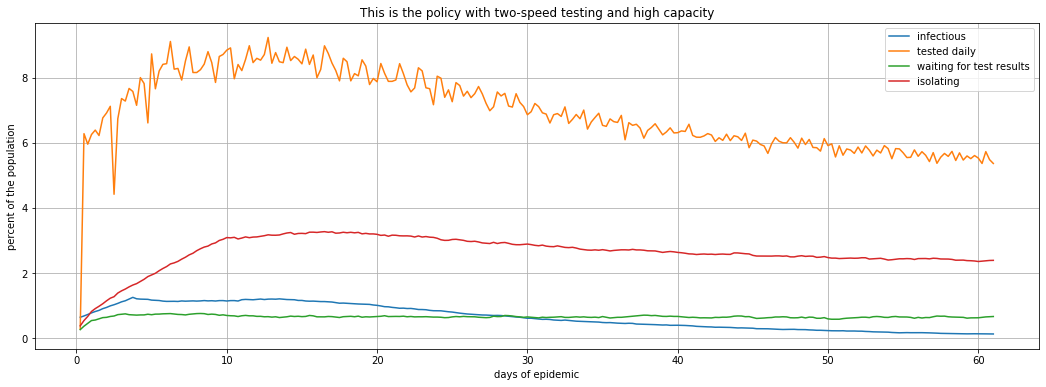

In [12]:
o.plot(title="This is the policy with two-speed testing and high capacity", 
               secondary_y=['prop_infected'])

# Next, take the records of the tests performed:

In [13]:
import pandas as pd

In [14]:
df = pd.DataFrame.from_dict(soc.test_recorder)

In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 663157 entries, 0 to 663156
Data columns (total 11 columns):
 #   Column                             Non-Null Count   Dtype  
---  ------                             --------------   -----  
 0   days_elapsed                       663157 non-null  float64
 1   person                             663157 non-null  object 
 2   positive                           663157 non-null  bool   
 3   days_to_complete                   663157 non-null  float64
 4   notes                              663157 non-null  object 
 5   days_delayed_start                 663157 non-null  float64
 6   _succeptible_contacts              663157 non-null  int64  
 7   _succeptible_contacts_of_contacts  663157 non-null  int64  
 8   _days_infected                     56043 non-null   float64
 9   _isolating                         663157 non-null  bool   
 10  swab_taken                         663157 non-null  bool   
dtypes: bool(3), float64(4), int64(2), objec

In [16]:
df['contacts'] = df.person.apply(lambda p: len(p.contacts))
df['_infected'] = df._days_infected > 0

In [17]:
cfg = soc.cfg
disease_duration = cfg.DAYS_BEFORE_INFECTIOUS + cfg.DAYS_INFECTIOUS_TO_SYMPTOMS + cfg.DAYS_OF_SYMPTOMS 
infectious_duration = cfg.DAYS_INFECTIOUS_TO_SYMPTOMS + cfg.DAYS_OF_SYMPTOMS 

In [18]:
df['_days_yet_infectious'] = df._days_infected.apply(lambda x: min(infectious_duration, disease_duration - x) if not pd.isnull(x) else 0)
df['_reducible_infection_potential'] = df.positive * df._succeptible_contacts * df._days_yet_infectious * cfg.PROB_INFECT_IF_TOGETHER_ON_A_DAY
df['_infection_potential'] = df._infected * df._succeptible_contacts * df._days_yet_infectious * cfg.PROB_INFECT_IF_TOGETHER_ON_A_DAY

In [19]:
df['_second_order_potential'] = df.positive * df._succeptible_contacts_of_contacts * df._days_yet_infectious * cfg.PROB_INFECT_IF_TOGETHER_ON_A_DAY

In [20]:
def simplify_notes(n):
    if type(n) == tuple and n[0] == 'contact':
        if n[1] == 1:
            return 'contact_1'
        return 'contact_2+'
    return n

In [21]:
df['notes'] = df.notes.apply(simplify_notes)

In [22]:
df[df._days_infected > 0].head()

,days_elapsed,person,positive,days_to_complete,notes,days_delayed_start,_succeptible_contacts,_succeptible_contacts_of_contacts,_days_infected,_isolating,swab_taken,contacts,_infected,_days_yet_infectious,_reducible_infection_potential,_infection_potential,_second_order_potential
0,0.25,person 141886,True,0.029109,symptoms,0.0,8,70,6.0,True,True,8,True,5.0,1.000,1.000,8.750
1,0.25,person 23116,True,0.083973,symptoms,0.0,16,211,6.0,True,True,16,True,5.0,2.000,2.000,26.375
2,0.25,person 37021,True,0.115496,symptoms,0.0,1,8,6.0,True,True,1,True,5.0,0.125,0.125,1.000
3,0.25,person 48278,True,0.244303,symptoms,0.0,5,36,6.0,True,True,5,True,5.0,0.625,0.625,4.500
4,0.25,person 77186,True,0.175725,symptoms,0.0,13,127,2.0,True,True,13,True,7.0,2.275,2.275,22.225


In [23]:
np.mean(df.contacts[df.positive])  #  * (df.notes.apply(lambda x: 'contact' in x))])

15.982517135194199

In [24]:
np.mean(df.positive) * np.mean(df.contacts[df.positive]) * 5

1.2131063986356172

### ML: we aim to learn `y` from `X`, so first lets define `X`:

In [25]:
np.unique(df.contacts)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26], dtype=int64)

In [26]:
set(df.notes)

{'contact_1', 'contact_2+', 'symptoms', 'valency'}

In [27]:
X = df[['notes', 'contacts']]

# Now implement a bootstrap study:

(this can be refined and much elaborated)

In [28]:
def outcomes(df, outcome, aggregation, agg_name='', index=None):
    index = index or ['notes', 'contacts']
    out = pd.pivot_table(df, values=outcome, index=index, aggfunc=aggregation)[outcome]
    try:
        out = out.unstack(0)
    except:
        pass
    out = pd.DataFrame(out.sort_index())
    out.columns = [x + "_" + agg_name for x in out.columns]
    return out

In [29]:
def bootstrap_resample(S):
    """
    @param S: a function that takes data and gives a statistic we want to know about
    @return: a new function that takes such data, and adds a smidge of randomness to get the bootstrap statistic
    """
    def func(Z):
        """
        @param Z: a numpy.array of data where the first dimension indexes the observations
        """
        Z_resampled = Z[np.random.randint(0, high=len(Z), size=len(Z))]
        return S(Z_resampled)
    return func

In [30]:
def bootstrap_std(x, f):
    return np.std([bootstrap_resample(f)(x.values) for i in range(0, 1000)], axis=0)

In [31]:
def plot_outcomes_with_error(df, outcome, agg, agg_name, index=None,max_contacts=50):
    means = outcomes(df, outcome, agg, agg_name=agg_name, index=index)
    stds = outcomes(df, outcome, lambda x: bootstrap_std(x, agg), agg_name='std', index=index)
    result = pd.concat([means, stds], axis=1)
    if max_contacts and (index is None):
        result = result[result.index < max_contacts]

    result[means.columns].plot(kind='bar', yerr=result[stds.columns].values.T * 2, alpha = 0.5,error_kw=dict(ecolor='k'), grid=True, title=agg_name + " " + outcome)
    plt.axhline(0,color='k')
    plt.axvline(0,color='k')
    return result

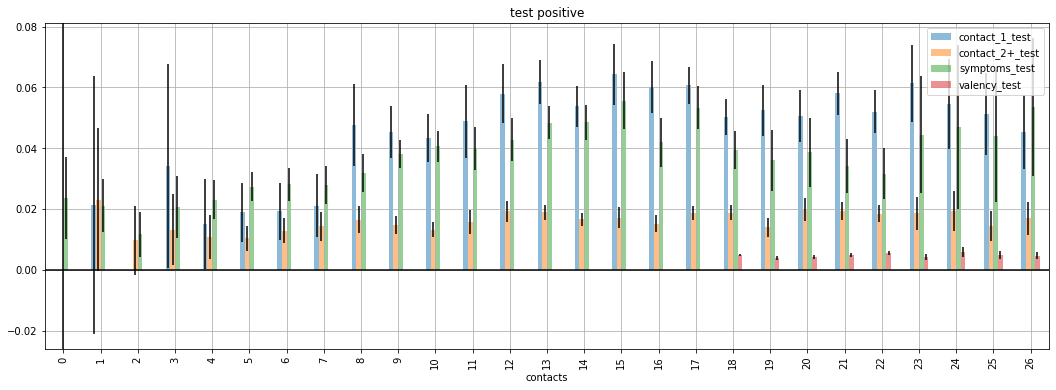

In [32]:
_ = plot_outcomes_with_error(df, 'positive', lambda x: min(0.5, np.mean(x)), 'test')

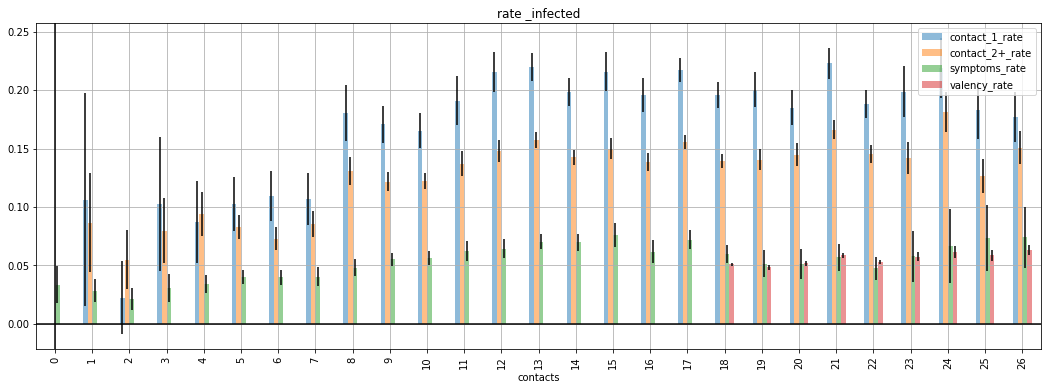

In [33]:
_ = plot_outcomes_with_error(df, '_infected', np.mean, 'rate')

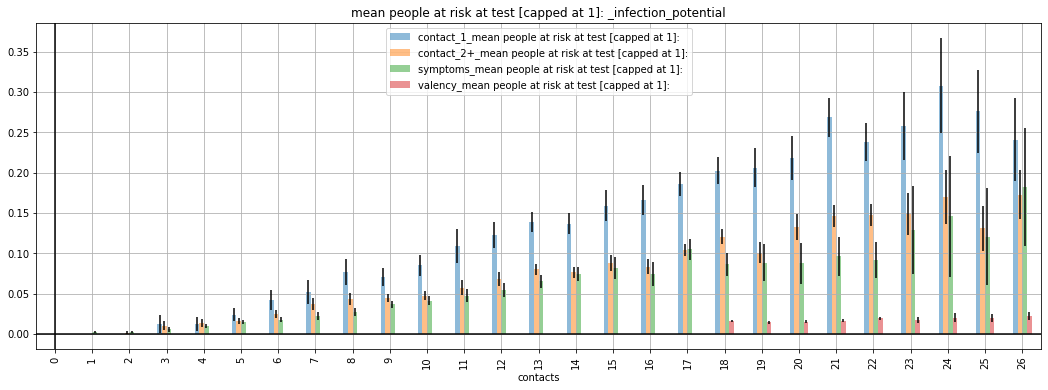

In [34]:
_ = plot_outcomes_with_error(df, '_infection_potential', lambda x: min(1, np.mean(x)), 
                             'mean people at risk at test [capped at 1]:')

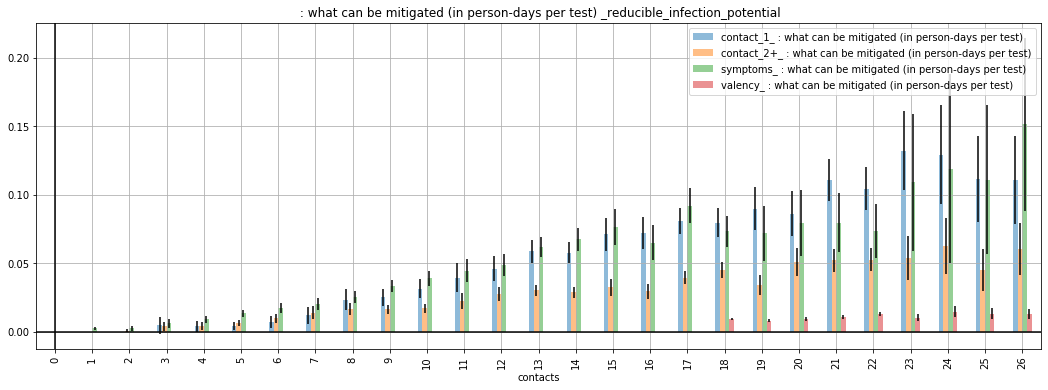

In [35]:
_ = plot_outcomes_with_error(df, '_reducible_infection_potential', lambda x: min(1.5, np.mean(x)),
                             ' : what can be mitigated (in person-days per test)')

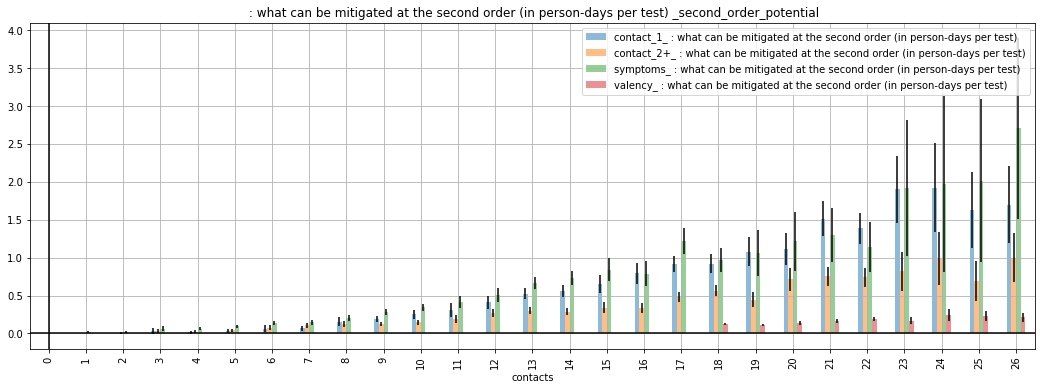

In [36]:
_ = plot_outcomes_with_error(df, '_second_order_potential', lambda x: min(20, np.mean(x)),
                             ' : what can be mitigated at the second order (in person-days per test)')

C:\Users\jerem\anaconda3\envs\tti\lib\site-packages\pandas\plotting\_matplotlib\core.py:572: UserWarning: The handle <BarContainer object of 4 artists> has a label of '_reducible_infection_potential_ : what can be mitigated (in person-days per test)' which cannot be automatically added to the legend.
  ax.legend(handles, labels, loc="best", title=title)


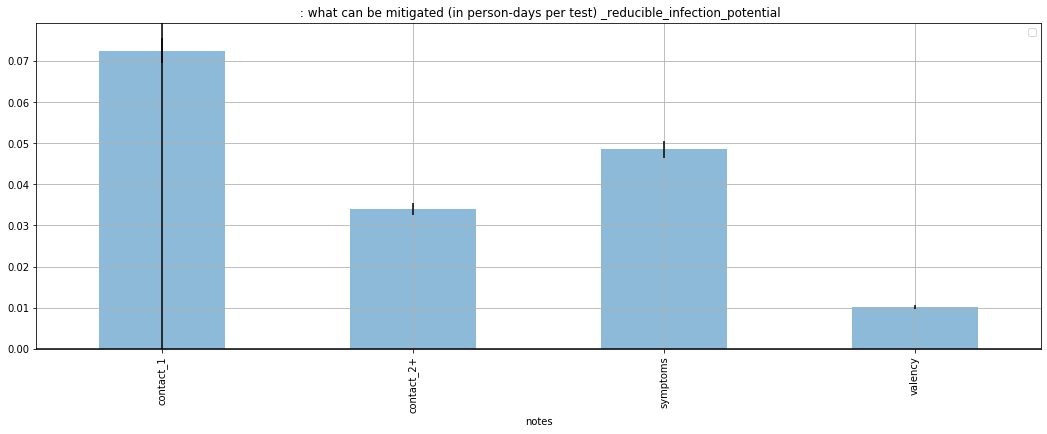

In [37]:
_ = plot_outcomes_with_error(df, '_reducible_infection_potential', np.mean, 
                             ' : what can be mitigated (in person-days per test)', index=['notes',], max_contacts=None)

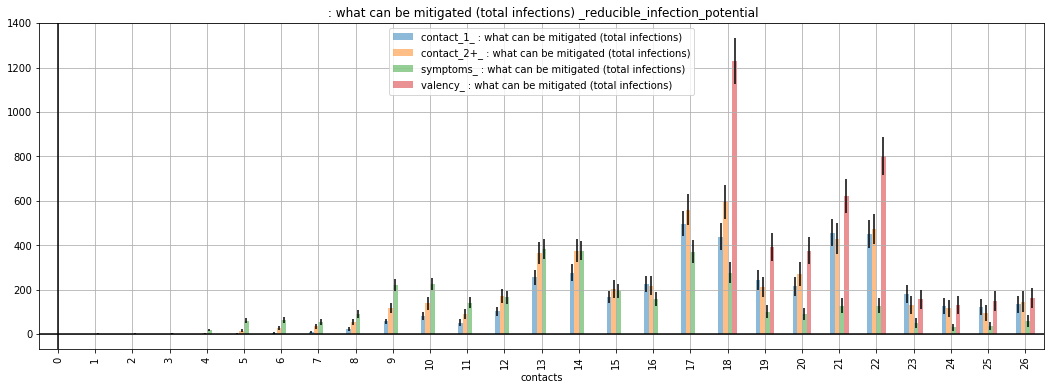

In [38]:
_ = plot_outcomes_with_error(df, '_reducible_infection_potential', np.sum, ' : what can be mitigated (total infections)')

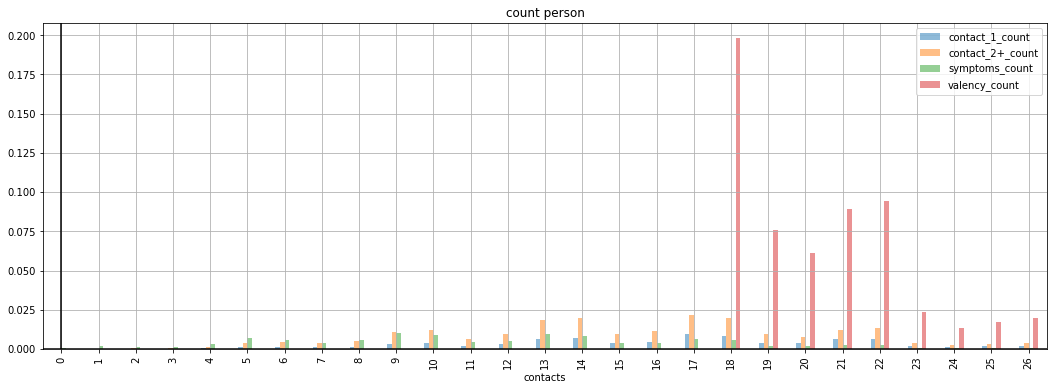

In [39]:
_ = plot_outcomes_with_error(df, 'person', lambda x: len(x) / len(df), 'count')

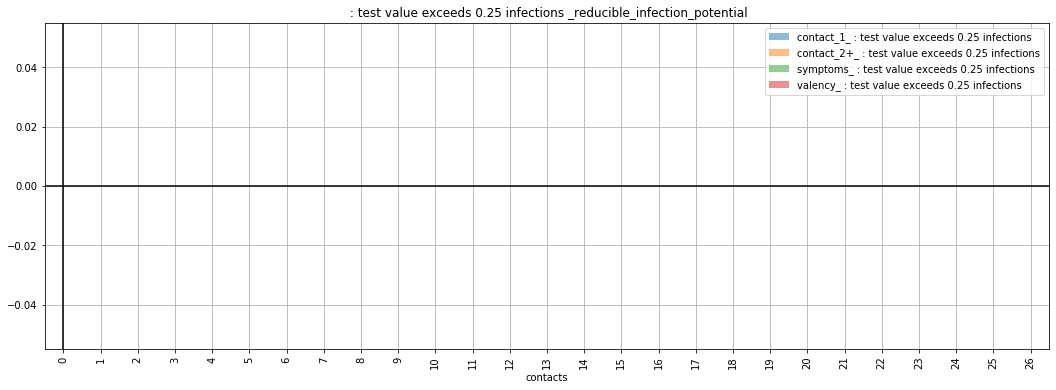

In [40]:
_ = plot_outcomes_with_error(df, '_reducible_infection_potential', lambda x: 1 * (np.mean(x) > 0.4),
                             ' : test value exceeds 0.25 infections')

In [41]:
means = outcomes(df, '_reducible_infection_potential', np.mean, agg_name='mean')

In [42]:
counts = outcomes(df, 'positive', len, agg_name='count')

In [43]:
np.nansum(counts.values)

663157.0

In [44]:
np.nansum(counts.values[means.values > 0.4])

C:\Users\jerem\anaconda3\envs\tti\lib\site-packages\ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in greater
  """Entry point for launching an IPython kernel.


0.0

In [45]:
nets = [len(p.contacts) for p in pop.people]

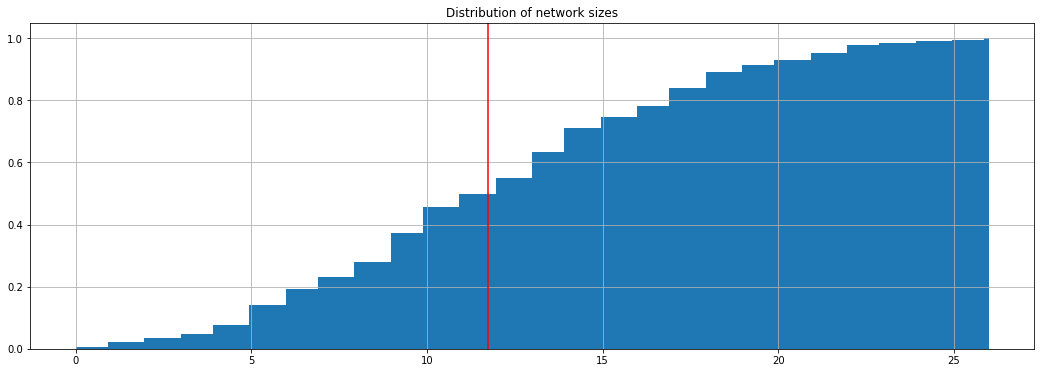

In [46]:
import matplotlib.pylab as plt
plt.hist(nets, cumulative=True, density=True, bins=200)
plt.title('Distribution of network sizes')
plt.axvline(np.mean(nets), color='r')
plt.grid()

In [47]:
len([n for n in nets if n > 25]) / len(nets) * 56000000

304410.2564102564

In [48]:
import networkx as nx

In [49]:
G = nx.Graph()

for g in pop.form_groupings(None):
    for i in g:
        for j in g:
            if i != j:
                G.add_edge(i, j)

In [50]:
len(G.nodes), len(G.edges)

(154907, 915650)

In [51]:
len(nx.algorithms.core.k_truss(G, 200).nodes)

0

In [ ]:
centers = nx.algorithms.centrality.betweenness_centrality(G, k = 30)

In [ ]:
betweeners = {p for p, c in centers.items() if c > 0.03125}

In [ ]:
betweeners, [p.age for p in betweeners]

In [ ]:
for g in pop.form_groupings(None):
    if len(g & betweeners):
        print([p.age for p in g])
        print(len(g))